### Importing libraries and modules:

In [205]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
 
import paneldata as lpd
from models import *
import mestim as M 

# Formatting

In [206]:
# prepare
dat = pd.read_csv("union.csv", delimiter=",")

dat = dat[dat.year < 1985]

In [207]:
N = dat.nr.unique().size
T = dat.year.unique().size
assert dat.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T}')

Data has N=545 and T=5


In [208]:
# constant column

dat['const']=np.ones((dat.shape[0],1))

In [209]:
# Add variables

addlag(dat, 'union', tid='year', t0 = 1980)


dat['union1']=dat['union'].groupby(dat['nr']).transform(lambda x: x.to_numpy()[0] )


y_it = ['union']
x_t = ['year']
x_it = ['married']
x_lag = ['l1.union']
x_i = ['educ']
const = ['const']
groupvar = 'nr'

In [210]:
display(dat.describe())
print('Within group standard deviation:'); print(dat.groupby('nr').std().mean().round(5)) 
print('Between group standard deviation:'); display(dat.groupby('nr').mean().std().round(5)) 

,nr,year,union,married,educ,const,l1.union,union1
count,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.0,2180.000000,2725.000000
mean,5262.058716,1982.000000,0.251009,0.355963,11.766972,1.0,0.250917,0.251376
std,3496.390456,1.414473,0.433673,0.478892,1.746302,0.0,0.433641,0.433884
min,13.000000,1980.000000,0.000000,0.000000,3.000000,1.0,0.000000,0.000000
25%,2329.000000,1981.000000,0.000000,0.000000,11.000000,1.0,0.000000,0.000000
50%,4569.000000,1982.000000,0.000000,0.000000,12.000000,1.0,0.000000,0.000000
75%,8406.000000,1983.000000,1.000000,1.000000,12.000000,1.0,1.000000,1.000000
max,12548.000000,1984.000000,1.000000,1.000000,16.000000,1.0,1.000000,1.000000


Within group standard deviation:
year        1.58114
union       0.17403
married     0.18941
educ        0.00000
const       0.00000
l1.union    0.16659
union1      0.00000
dtype: float64
Between group standard deviation:


year        0.00000
union       0.34615
married     0.39141
educ        1.74759
const       0.00000
l1.union    0.35029
union1      0.43420
dtype: float64

In [211]:
lpm_fe=lpd.estim(dat.dropna(), y_it, xvar=x_lag+x_it+x_t , groupvar='nr', method='fe', cov_type='robust')
lpm_pols=lpd.estim(dat.dropna(), y_it, xvar=x_lag+x_it+x_t+x_i+const, groupvar='nr', method='pols', cov_type='robust')


Specification: Linear Fixed Effects Regression
Dep. var. : ['union'] 

parnames         b_hat          se    t-values
----------  ----------  ----------  ----------
l1.union       -0.0719      0.0329     -2.1846
married        -0.0153      0.0271     -0.5652
year            0.0005      0.0062      0.0798
# of groups:       545
# of observations: 2180 


Specification: Pooled OLS Panel Regression
Dep. var. : ['union'] 

parnames         b_hat          se    t-values
----------  ----------  ----------  ----------
l1.union        0.6136      0.0256     23.9673
married         0.0200      0.0153      1.3046
year           -0.0014      0.0054     -0.2655
educ           -0.0010      0.0038     -0.2640
const           2.9640     10.7831      0.2749
# of groups:       545
# of observations: 2180 



In [212]:
def Q_pooled(y, x, T, beta, model='probit', out='Q'):
    ''' Pooled linear index model for panel data. e.g pooled probit or logit
        y:      Nobs x 1 np.array of binary response data
        x:      Nobs x k np.array of explanatory variables
        T:      n x 1  np.array of containing number of time observations for each group 
        model:  'probit' or 'logit'
        out:    controls what is returned - can be 'predict','Q', 'dQ', 's_i', or 'H'
    '''

    beta=np.array(beta).reshape(-1,1)             # parameters
    n=T.shape[0];                                 # number of groups
    xb=x @ beta                                   # Linear index 
    Gx=G(xb, model)                               # Response probability at x
    gx=g(xb, model)                               # Density at xb
    Gx=np.minimum(np.maximum(Gx,1e-15),1-1e-15)   # Truncating Gx
    if out=='predict':  return xb, Gx, gx         # Return predicted values

    ll_it = np.log(Gx)*y + np.log(1-Gx)*(1-y)     # Nobsx1 vector of log-likelihood contributions for group i at time t
    q_i= - sumby(ll_it, T)                        # nx1 vector of (negative) log-likelihood contributions 
    if out=='Q': return np.mean(q_i);             # Return Q: sample objective function to be minimized - negative of log-likelihood

    # 1st order derivatives
    s_it=gx*x*(y-Gx)/( Gx* (1-Gx))                # NobsxK array of derivatives of ll_it
    s_i = sumby(s_it, T)                          # nxK array of derivatives of ll_i (transposed scores staked over i)
    if out=='s_i': return s_i                     # Return s_i: nxK array with scores
    if out=='dQ':  return -np.mean(s_i, axis=0);  # Return dQ: array of size K derivative of sample objective function

    # 2nd order derivatives
    H=(gx*x).T @(gx*x/(Gx* (1-Gx)))/n             # Analytical Hessian averaged over all groups i
    # H=s_it.T@ s_it/n                            # Alternative: use product of gradient as Hessian approximation
    if out=='H':    return H; 

In [213]:
def avar(s_i, Ainv, cov_type ='sandwich'):
    n, K=s_i.shape
    B=s_i.T@ s_i/n 
    if cov_type=='Binv':        return la.inv(B)/n
    if cov_type=='Ainv':        return Ainv/n;         
    if cov_type=='sandwich':    return Ainv @ B @ Ainv/n

In [214]:
def pooled(df, yvar, xvar, groupvar, model='probit', cov_type='sandwich', deriv=1): 
    print('Pooled', model)
    Nobs, k, n, T, y, x = panel_setup(df, yvar, xvar, groupvar)
    Qfun     = lambda beta, out:  Q_pooled(y, x, T, beta, model, out)
    res=M.estimation(Qfun, theta0=np.zeros((k)), deriv=deriv, cov_type=cov_type, parnames=xvar)
    xb, Gx, gx = Qfun(res.theta_hat, out='predict')
    APE=np.mean(gx)*res.theta_hat
    res.update(dict(zip(['yvar', 'xvar', 'Nobs','k', 'n', 'T', 'APE'], [yvar, xvar, Nobs, k, n, T, APE])))
    print_output(res)
    return res

In [215]:
# Estimate probit model

res_dyn_pp = pooled(dat.dropna(), y_it, xvar=x_lag+x_it+x_i+x_t+const, groupvar=groupvar, model='probit')

Pooled probit
Dep. var. : ['union'] 

parnames      theta_hat          se    t-values         jac         APE
----------  -----------  ----------  ----------  ----------  ----------
l1.union        1.85545     0.09046    20.51182    -0.00000     0.39666
married         0.08811     0.06742     1.30697    -0.00000     0.01884
educ           -0.01020     0.01974    -0.51695    -0.00000    -0.00218
year           -0.01444     0.02499    -0.57808    -0.00000    -0.00309
const          27.41808    49.53445     0.55352    -0.00000     5.86154

# of groups:      : 545
# of observations : 2180
# log-likelihood. : -846.9941576129829 

Iteration info: 41 iterations, 47 evaluations of objective, and 47 evaluations of gradients
Elapsed time: 0.1409 seconds



In [216]:
# Create time-specific married variables
for t, year in enumerate(sorted(dat.year.unique()), 1):
    dat[f'married{t}'] = dat['married'] * (dat.year == year).astype(int)

# Confirm the new variables exist
print(dat.columns)

Index(['nr', 'year', 'union', 'married', 'educ', 'const', 'l1.union', 'union1',
       'married1', 'married2', 'married3', 'married4', 'married5'],
      dtype='object')


In [217]:
# Dynamic probit model

z_i=['married1', 'married2', 'married3', 'married4', 'union1']
res_dyn_pp_controls=pooled(dat.dropna(), y_it, xvar=x_lag + x_it + x_i +x_t + const + z_i , groupvar='nr', model='probit')

Pooled probit
Dep. var. : ['union'] 

parnames      theta_hat          se          t-values         jac         APE
----------  -----------  ----------  ----------------  ----------  ----------
l1.union        1.60819     0.08637          18.61993     0.00000     0.33624
married         0.21643     0.10300           2.10130     0.00000     0.04525
educ           -0.00975     0.01809          -0.53908     0.00000    -0.00204
year           -0.02822     0.03339          -0.84524     0.00000    -0.00590
const          54.66895    66.21308           0.82565     0.00000    11.43000
married1        0.00000     0.00000         nan          -0.00000     0.00000
married2       -0.31097     0.17637          -1.76319    -0.00000    -0.06502
married3        0.02586     0.13628           0.18978     0.00000     0.00541
married4       -0.31985     0.11591          -2.75957    -0.00000    -0.06687
union1          0.46966     0.08649           5.42993     0.00000     0.09819

# of groups:      : 545
#

/Users/rohdee/Github/EconometricsB/Assignment 2/mestim.py:40: RuntimeWarning: invalid value encountered in divide
  results = [parnames, theta_hat, se, theta_hat/se, cov, Q(theta_hat), toc - tic, s_i]


In [218]:
# Dynamic random effects probit model

sigma_a0=1
theta0=res_dyn_pp_controls.theta_hat*np.sqrt(1+sigma_a0**2)
theta0=np.append(theta0,sigma_a0)
res_dynrep=rand_effect(dat.dropna(), y_it, xvar=x_lag + x_it + x_i + x_t + const + z_i, groupvar='nr', model='probit', theta0=theta0)

Random effects probit
Dep. var. : ['union'] 

parnames      theta_hat          se    t-values         jac         APE
----------  -----------  ----------  ----------  ----------  ----------
l1.union        0.70409     0.12441     5.65939    -0.00000     0.10976
married         0.24553     0.17277     1.42111    -0.00000     0.03828
educ           -0.02053     0.04311    -0.47626    -0.00000    -0.00320
year           -0.05762     0.05099    -1.12983    -0.00001    -0.00898
const         112.53559   101.09199     1.11320    -0.00000    17.54377
married1        0.00000     0.04284     0.00000    -0.00000     0.00000
married2       -0.45832     0.24447    -1.87475    -0.00000    -0.07145
married3        0.00699     0.19708     0.03548    -0.00000     0.00109
married4       -0.39917     0.17333    -2.30300    -0.00000    -0.06223
union1          1.80549     0.23354     7.73098    -0.00000     0.28147
sigma_a         1.25009     0.13301     9.39876     0.00000     0.19488

# of groups:     

In [219]:
# Compute APE in DRE probit
Nobs, k, n, T, y, x = panel_setup(dat.dropna(), y_it,  
   xvar=x_lag +x_it + x_i +x_t + const + z_i , groupvar='nr')
sigma_a_hat=res_dynrep.theta_hat[-1];
beta_hat_a=res_dynrep.theta_hat[0:-1]/np.sqrt(1+sigma_a_hat**2)

rho_hat=beta_hat_a[0,0];
beta_hat_a0=beta_hat_a.copy()
beta_hat_a0[0,0]=0;
Px0=G(x@beta_hat_a0, 'probit')
Px1=G(x@beta_hat_a0 + rho_hat, 'probit')
PE_lagy_RE=Px1-Px0 
print('State dependence estimated by dynamic random effects probit:',np.mean(PE_lagy_RE))

# Compute APE in DP probit
Nobs, k, n, T, y, x = panel_setup(dat.dropna(), y_it,  
                                  xvar=x_lag + x_it + x_i + x_t + const, groupvar='nr')
beta_hat_a=res_dyn_pp.theta_hat
rho_hat=beta_hat_a[0,0];
beta_hat_a0=beta_hat_a.copy()
beta_hat_a0[0,0]=0;
Px0=G(x@beta_hat_a0, 'probit')
Px1=G(x@beta_hat_a0 + rho_hat, 'probit')
PE_lagy_Pooled=Px1-Px0 
print('State dependence estimated by dynamic pooled probit:',np.mean(PE_lagy_Pooled))

# with controls for correlation with x_it
Nobs, k, n, T, y, x = panel_setup(dat.dropna(), y_it,  
                                  xvar=x_lag + x_it + x_i + x_t + const + z_i, groupvar='nr')
beta_hat_a=res_dyn_pp_controls.theta_hat
rho_hat=beta_hat_a[0,0];
beta_hat_a0=beta_hat_a.copy()
beta_hat_a0[0,0]=0;
Px0=G(x@beta_hat_a0, 'probit')
Px1=G(x@beta_hat_a0 + rho_hat, 'probit')
PE_lagy_Pooled_control=Px1-Px0 
print('State dependence estimated by dynamic pooled probit with correlation control:',np.mean(PE_lagy_Pooled_control))

State dependence estimated by dynamic random effects probit: 0.1248689442873571
State dependence estimated by dynamic pooled probit: 0.6132590144591632
State dependence estimated by dynamic pooled probit with correlation control: 0.5240994015937617


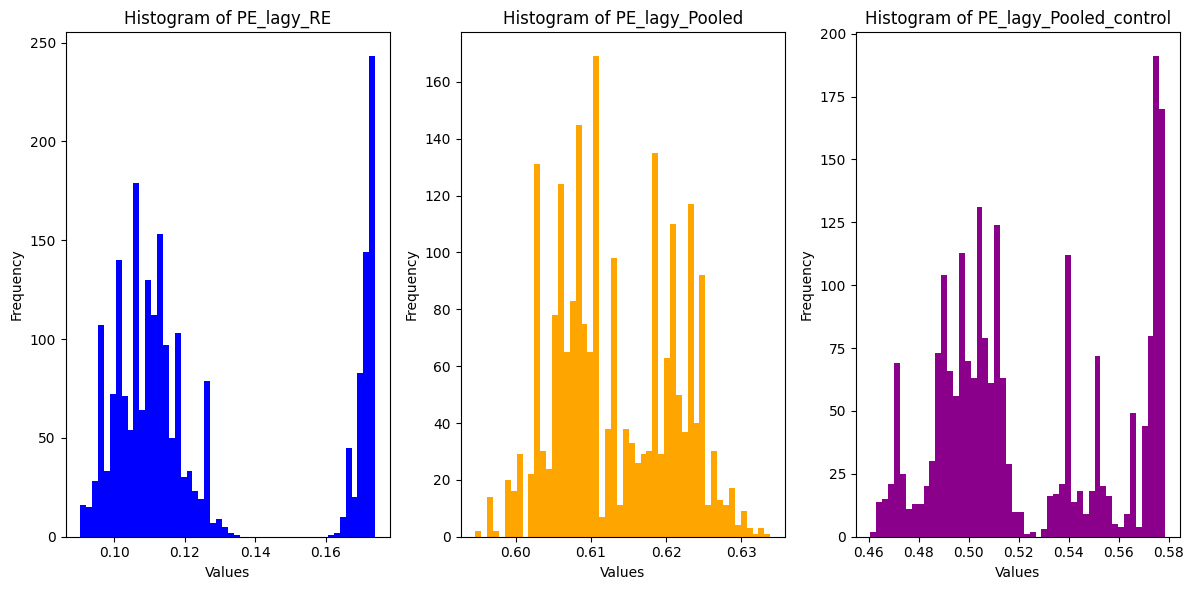

In [220]:
# plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

axes[0].hist(PE_lagy_RE, bins=50, color='blue')
axes[0].set_title('Histogram of PE_lagy_RE')
axes[0].set_xlabel('Values')
axes[0].set_ylabel('Frequency')

axes[1].hist(PE_lagy_Pooled, bins=50, color='orange')
axes[1].set_title('Histogram of PE_lagy_Pooled')
axes[1].set_xlabel('Values')
axes[1].set_ylabel('Frequency')


axes[2].hist(PE_lagy_Pooled_control, bins=50, color='darkmagenta')
axes[2].set_title('Histogram of PE_lagy_Pooled_control')
axes[2].set_xlabel('Values')
axes[2].set_ylabel('Frequency')


plt.tight_layout()

plt.show()